### Phase 1: Exploration et nettoyage des données

Importation des librairies 

In [70]:
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Initialisation de la session Spark:

In [ ]:
spark = SparkSession.builder \
    .appName("Analyse_US_Accidents") \
    .master("local[*]") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.3") \
    .getOrCreate()

Charger le jeu de données CSV à partir de HDFS:

In [71]:
df = spark.read.load('hdfs://localhost:8020/user/root/US_Accidents_Dec21_updated.csv', format='com.databricks.spark.csv',header='true',sep=',',inferSchema='true')

##### Exploration du jeu de données:

Afficher le schéma de données du DataFrame:

In [72]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Number: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(

In [73]:
nb_row = df.count()
print("Le nombre total de ligne:", nb_row )

Le nombre total de ligne: 2845342


In [74]:
num_cols = len(df.columns)
print('Le nombre de colonnes dans le jeu de données est :', num_cols)

Le nombre de colonnes dans le jeu de données est : 47



Le nombre de valeurs distinctes pour chaque colonne du DataFrame Spark:

In [5]:
from pyspark.sql.functions import countDistinct

for col in df.columns:
    num_distinct_values = df.select(countDistinct(col)).collect()[0][0]
    print(f"{col}: {num_distinct_values}")

ID: 2845342
Severity: 4
Start_Time: 1807311
End_Time: 2239983
Start_Lat: 1093622
Start_Lng: 1120375
End_Lat: 1080817
End_Lng: 1105411
Distance(mi): 14165
Description: 1174563
Number: 46402
Street: 159651
Side: 3
City: 11681
County: 1707
State: 49
Zipcode: 363085
Country: 1
Timezone: 4
Airport_Code: 2004
Weather_Timestamp: 474214
Temperature(F): 789
Wind_Chill(F): 897
Humidity(%): 100
Pressure(in): 1068
Visibility(mi): 76
Wind_Direction: 24
Wind_Speed(mph): 136
Precipitation(in): 230
Weather_Condition: 127
Amenity: 2
Bump: 2
Crossing: 2
Give_Way: 2
Junction: 2
No_Exit: 2
Railway: 2
Roundabout: 2
Station: 2
Stop: 2
Traffic_Calming: 2
Traffic_Signal: 2
Turning_Loop: 1
Sunrise_Sunset: 2
Civil_Twilight: 2
Nautical_Twilight: 2
Astronomical_Twilight: 2


Extraire les valeurs distinctes de la colonne 'Severity'

In [49]:
severity_values = df.select('Severity').distinct().rdd.flatMap(lambda x: x).collect()

print(severity_values)

[1, 3, 4, 2]


Visualiser le pourcentage de la répartition des valeurs de 'Severity':

In [50]:
from pyspark.sql.functions import count, format_number

total = df.count()

severity_percentages = df.groupBy('Severity').agg((count('*')/total*100).alias('Percentage'))

severity_percentages = severity_percentages.withColumn('Percentage', format_number('Percentage', 2))

severity_percentages.show()

+--------+----------+
|Severity|Percentage|
+--------+----------+
|       1|      0.92|
|       3|      5.45|
|       4|      4.61|
|       2|     89.02|
+--------+----------+



Afficher le nombre de valeur nulle pour chaque colonne du Dataframe:

In [9]:
from pyspark.sql.functions import sum, col

null_counts = df.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

null_counts_pd = null_counts.toPandas()

null_counts_pd = null_counts_pd.set_index(null_counts.columns[0])

null_counts_pd = null_counts_pd.T

print("Le nombre de valeur nulle pour chaque colonne")
print(null_counts_pd)

Le nombre de valeur nulle pour chaque colonne
ID                           0
Severity                     0
Start_Time                   0
End_Time                     0
Start_Lat                    0
Start_Lng                    0
End_Lat                      0
End_Lng                      0
Distance(mi)                 0
Description                  0
Number                 1743911
Street                       2
Side                         0
City                       137
County                       0
State                        0
Zipcode                   1319
Country                      0
Timezone                  3659
Airport_Code              9549
Weather_Timestamp        50736
Temperature(F)           69274
Wind_Chill(F)           469643
Humidity(%)              73092
Pressure(in)             59200
Visibility(mi)           70546
Wind_Direction           73775
Wind_Speed(mph)         157944
Precipitation(in)       549458
Weather_Condition        70636
Amenity                 

##### Interpretation du resultat de parcours des colonnes:

Le résultat affiche le nombre de valeurs distinctes pour chaque colonne dans le dataframe. On peut remarquer que certaines colonnes ont un nombre de valeurs distinctes très faible, comme la colonne "Turning_Loop" qui n'a qu'une seule valeur distincte. Il peut être judicieux de supprimer ces colonnes qui ne contiennent pas d'informations utiles pour notre analyse.

D'autre part, certaines colonnes ont un grand nombre de valeurs distinctes, comme la colonne "Description" qui a plus de 1 million de valeurs distinctes. Pour ces colonnes, il peut être utile de faire une analyse plus approfondie pour comprendre la distribution des valeurs et éventuellement réduire le nombre de valeurs distinctes en regroupant certaines valeurs similaires.

Enfin, on peut remarquer que certaines colonnes sont catégorielles, comme la colonne "State" qui n'a que 49 valeurs distinctes. Pour ces colonnes, il peut être intéressant de créer des graphiques pour visualiser la distribution des valeurs et comprendre les tendances géographiques des accidents de la route.



Génère un diagramme à barres pour visualiser la répartition des valeurs manquantes dans le DataFrame Spark 

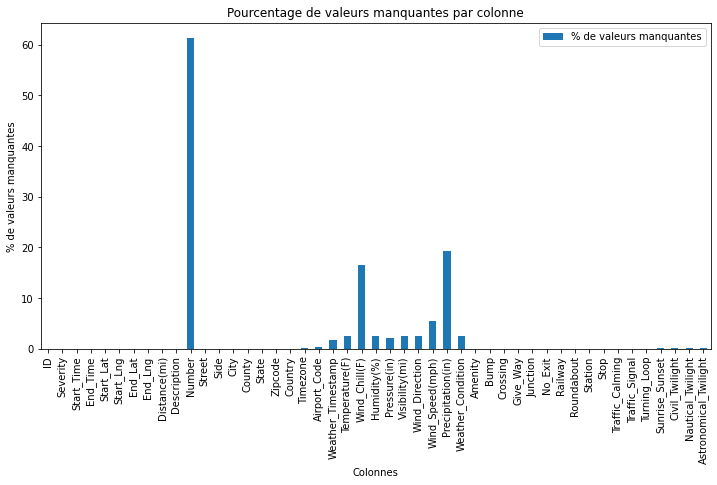

In [11]:
import matplotlib.pyplot as plt

missing_percentages = df.select([(sum(col(c).isNull().cast("int")) / df.count() * 100).alias(c) for c in df.columns])

missing_percentages_pd = missing_percentages.toPandas().transpose()
missing_percentages_pd.columns = ['% de valeurs manquantes']

missing_percentages_pd.plot(kind='bar', figsize=(12,6))
plt.title('Pourcentage de valeurs manquantes par colonne')
plt.xlabel('Colonnes')
plt.ylabel('% de valeurs manquantes')
plt.show()

Calcul de la durée moyenne d'un accident de voiture, entre la date du début de l'accident et sa fin, cela permet de déduire si la colonne 'End_time' est representative 

In [8]:
from pyspark.sql.functions import when, round, expr, col

df = df.withColumn("Duration", (col("End_Time").cast("long") - col("Start_Time").cast("long")) / 60)

df = df.withColumn("Duration_Rounded", round(col("Duration"), 3))

mean_duration = df.select(expr("round(avg(Duration_Rounded), 3)").alias("mean_duration")).collect()[0]["mean_duration"]

print("La duration moyenne: ", mean_duration, 'min')

La duration moeynne:  359.034 min


##### Nettoyage du jeu de données:

Suppression des colonnes non utiles à l'analyse:

In [75]:
df = df.drop('Distance', 'End_Time', 'Street','Amenity','Give_Way','Bump','No_Exit','Railway','Roundabout','Stop','Traffic_Calming','Duration','Number', 'Timezone','End_Lat', 'End_Lng', 'Wind_Chill(F)', 'Zipcode', 'Airport_Code' )

In [76]:
df= df.drop('Country', 'Turning_Loop')

Suppression de toutes les lignes contenant des valeurs manquantes pour les colonnes liés à la période de la journée, étant donné que ces variables ont le même nombre de données manquantes 

In [77]:
df = df.dropna(subset=['City','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'])

Remplacer les valeurs manquantes pour les colonnes liés aux attributs météorologiques par leur médianes:

In [78]:
from pyspark.sql.functions import col

humidity_median = df.approxQuantile("Humidity(%)", [0.5], 0.25)[0]
pressure_median = df.approxQuantile("Pressure(in)", [0.5], 0.25)[0]
visibility_median = df.approxQuantile("Visibility(mi)", [0.5], 0.25)[0]
temperature_median = df.approxQuantile("Temperature(F)", [0.5], 0.25)[0]

df = df.withColumn("Humidity(%)", when(col("Humidity(%)").isNull(), humidity_median).otherwise(col("Humidity(%)")))
df = df.withColumn("Pressure(in)", when(col("Pressure(in)").isNull(), pressure_median).otherwise(col("Pressure(in)")))
df = df.withColumn("Visibility(mi)", when(col("Visibility(mi)").isNull(), visibility_median).otherwise(col("Visibility(mi)")))
df = df.withColumn("Temperature(F)", when(col("Temperature(F)").isNull(), temperature_median).otherwise(col("Temperature(F)")))

Afficher les differentes valeurs de l'attribut 'Wind_Direction'

In [57]:
print("Wind Direction: ", df.select("Wind_Direction").distinct().rdd.flatMap(lambda x: x).collect())

Wind Direction:  ['SSE', 'SW', 'NW', 'Calm', None, 'E', 'WSW', 'ENE', 'NE', 'South', 'NNW', 'N', 'SSW', 'W', 'S', 'SE', 'East', 'WNW', 'NNE', 'West', 'VAR', 'CALM', 'ESE', 'Variable', 'North']


Remplacer les valeurs de la colonne 'Wind_Direction' par des valeurs simplifiées:

In [79]:
from pyspark.sql.functions import when

df = df.withColumn("Wind_Direction", \
                   when(col("Wind_Direction") == "Calm", "CALM") \
                   .when(col("Wind_Direction").isin(["West", "WSW", "WNW"]), "W") \
                   .when(col("Wind_Direction").isin(["South", "SSW", "SSE"]), "S") \
                   .when(col("Wind_Direction").isin(["North", "NNW", "NNE"]), "N") \
                   .when(col("Wind_Direction").isin(["East", "ESE", "ENE"]), "E") \
                   .when(col("Wind_Direction") == "Variable", "VAR") \
                   .otherwise(col("Wind_Direction")))

print("Wind Direction after simplification: ", df.select("Wind_Direction").distinct().rdd.flatMap(lambda x: x).collect())

Wind Direction after simplification:  ['SW', 'NW', None, 'E', 'NE', 'N', 'W', 'S', 'SE', 'VAR', 'CALM']


Afficher les differentes valeurs de l'attribut 'Weather_Condition'

In [80]:
from pyspark.sql.functions import col

print("Weather_Condition: ")
df.select(col('Weather_Condition')).distinct().show()

Weather_Condition: 
+--------------------+
|   Weather_Condition|
+--------------------+
|Light Rain Shower...|
|         Ice Pellets|
|         Shallow Fog|
|        Thunderstorm|
|Light Snow with T...|
|         Light Sleet|
|  Light Snow / Windy|
|   N/A Precipitation|
|        Volcanic Ash|
|           Duststorm|
|Freezing Rain / W...|
| Blowing Snow Nearby|
|Showers in the Vi...|
|   Heavy Ice Pellets|
|              Cloudy|
|    Thunder and Hail|
|  Wintry Mix / Windy|
|     T-Storm / Windy|
| Light Freezing Rain|
|          Wintry Mix|
+--------------------+
only showing top 20 rows



Répartir des données de 'Weather_Condition' sur plusieurs nouvelles colonnes booléennes:

In [3]:
from pyspark.sql.functions import when, col

df = df.withColumn('Clear', when(col('Weather_Condition').rlike('Clear|clear'), True).otherwise(False))

df = df.withColumn('Cloud', when(col('Weather_Condition').rlike('Cloud|cloud|Overcast|overcast'), True).otherwise(False))

df = df.withColumn('Rain', when(col('Weather_Condition').rlike('Rain|rain|Storm|storm'), True).otherwise(False))

df = df.withColumn('Heavy_Rain', when(col('Weather_Condition').rlike('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms'), True).otherwise(False))

df = df.withColumn('Snow', when(col('Weather_Condition').rlike('Snow|snow|Sleet|sleet|Ice|ice'), True).otherwise(False))

df = df.withColumn('Heavy_Snow', when(col('Weather_Condition').rlike('Heavy Snow|Heavy Sleet|Heavy Ice Pellets|Snow Showers|Squalls'), True).otherwise(False))

df = df.withColumn('Fog', when(col('Weather_Condition').rlike('Fog|fog'), True).otherwise(False))

df.select('Clear', 'Cloud', 'Rain', 'Heavy_Rain', 'Snow', 'Heavy_Snow', 'Fog').show(5)

ModuleNotFoundError: No module named 'pyspark'

Explorer le format des dates du DataFrame:

In [83]:
from pyspark.sql.functions import col

print("Extrait des 10 premieres dates enregistrées dans le dataframe:")
df.select(col("Start_Time")).show(10)

Extrait des 10 premieres dates enregistrées dans le dataframe:
+-------------------+
|         Start_Time|
+-------------------+
|2016-02-08 00:37:08|
|2016-02-08 05:56:20|
|2016-02-08 06:15:39|
|2016-02-08 06:51:45|
|2016-02-08 07:53:43|
|2016-02-08 08:16:57|
|2016-02-08 08:15:41|
|2016-02-08 11:51:46|
|2016-02-08 14:19:57|
|2016-02-08 15:16:43|
+-------------------+
only showing top 10 rows



Calcul de la différence entre les colonnes "Start_Time" et "Weather_Timestamp":

In [84]:
from pyspark.sql.functions import col, mean
from datetime import timedelta

diff_col = (col("Weather_Timestamp").cast("long") - col("Start_Time").cast("long")).alias("diff")

mean_diff = df.select(diff_col).agg(mean("diff")).collect()[0][0]

mean_diff_timedelta = timedelta(milliseconds=mean_diff)

print("La difference moyenne entre 'Start_Time' et 'Weather_Timestamp': ", mean_diff_timedelta)

La difference moyenne entre 'Start_Time' et 'Weather_Timestamp':  0:00:00.071819


La différence est très faible, on peut déduire que l'attribut 'Weather_Timestamp' n'apporte pas de valeurs ajoutée et peut être supprimé

In [85]:
df = df.drop('Weather_Timestamp')

 Extraire les données temporaires à partir de la colonne 'Start_Time' et les stocke dans des colonnes distinctes:

In [86]:
from pyspark.sql.functions import year, month, dayofweek, dayofmonth, hour, minute

df = df.withColumn('Year', year('Start_Time'))

df = df.withColumn('Month', month('Start_Time'))

df = df.withColumn('Weekday', dayofweek('Start_Time'))

df = df.withColumn('Day', dayofmonth('Start_Time'))

df = df.withColumn('Hour', hour('Start_Time'))

df = df.withColumn('Minute', hour('Start_Time')*60.0 + minute('Start_Time'))

df.select('Start_Time', 'Year', 'Month', 'Weekday', 'Day', 'Hour', 'Minute').show(5)

+-------------------+----+-----+-------+---+----+------+
|         Start_Time|Year|Month|Weekday|Day|Hour|Minute|
+-------------------+----+-----+-------+---+----+------+
|2016-02-08 00:37:08|2016|    2|      2|  8|   0|  37.0|
|2016-02-08 05:56:20|2016|    2|      2|  8|   5| 356.0|
|2016-02-08 06:15:39|2016|    2|      2|  8|   6| 375.0|
|2016-02-08 06:51:45|2016|    2|      2|  8|   6| 411.0|
|2016-02-08 07:53:43|2016|    2|      2|  8|   7| 473.0|
+-------------------+----+-----+-------+---+----+------+
only showing top 5 rows



Ajouter une nouvelle colonnées 'Precipitation_NA' avec les données de 'Precipitation(in)' qui existe déjà et remplacer ces valeurs manquantes par la médiane

In [87]:
from pyspark.sql.functions import col, when, lit

df = df.withColumn("Precipitation_NA", lit(0))

df = df.withColumn("Precipitation_NA", when(col("Precipitation(in)").isNull(), 1).otherwise(col("Precipitation_NA")))

median_val = df.approxQuantile("Precipitation(in)", [0.5], 0.001)[0]

df = df.withColumn("Precipitation(in)", when(col("Precipitation(in)").isNull(), median_val).otherwise(col("Precipitation(in)")))

##### Convertir le DataFrame Spark mis à jour en DataFrame Pandas:

Etant données que le DataFrame Spark est d'une grande taille, il a fallu trouvé une solution optimale qui va permettre de convertir le df Spark en Pandas.

Pour cela, nous avons défini 10 chunks, leur taille a été défini par rapport à la taille globale du DataFrame.

Ensuite, le script va lire les données du DataFrame Spark en petits morceaux (chunks) sous forme de Pandas DataFrame en utilisant la méthode toPandas(). Il divise les données en "num_chunks" (10) et lit chaque partie en utilisant "chunk_size" (une taille prédéfinie). Finalement le script concatene les chunks en un seul DataFrame Pandas

In [88]:
num_chunks = 10

chunk_size = int(df.count() / num_chunks)

chunks = [df.limit(chunk_size).toPandas() for i in range(num_chunks)]

df_pandas = pd.concat(chunks, ignore_index=True)

In [89]:
df_pandas.head()

,ID,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Description,Side,City,County,...,Snow,Heavy_Snow,Fog,Year,Month,Weekday,Day,Hour,Minute,Precipitation_NA
0,A-1,3,2016-02-08 00:37:08,40.108910,-83.092860,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,R,Dublin,Franklin,...,False,False,False,2016,2,2,8,0,37.0,0
1,A-2,2,2016-02-08 05:56:20,39.865420,-84.062800,0.747,At OH-4/OH-235/Exit 41 - Accident.,R,Dayton,Montgomery,...,False,False,False,2016,2,2,8,5,356.0,0
2,A-3,2,2016-02-08 06:15:39,39.102660,-84.524680,0.055,At I-71/US-50/Exit 1 - Accident.,R,Cincinnati,Hamilton,...,False,False,False,2016,2,2,8,6,375.0,0
3,A-4,2,2016-02-08 06:51:45,41.062130,-81.537840,0.123,At Dart Ave/Exit 21 - Accident.,R,Akron,Summit,...,False,False,False,2016,2,2,8,6,411.0,1
4,A-5,3,2016-02-08 07:53:43,39.172393,-84.492792,0.500,At Mitchell Ave/Exit 6 - Accident.,R,Cincinnati,Hamilton,...,False,False,False,2016,2,2,8,7,473.0,0


In [92]:
df_pandas.tail()

,ID,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Description,Side,City,County,...,Snow,Heavy_Snow,Fog,Year,Month,Weekday,Day,Hour,Minute,Precipitation_NA
2842465,A-284402,2,2021-11-05 10:28:30,34.164501,-118.623293,2.012,Slow traffic on Ventura Fwy E - US-101 S from ...,R,Woodland Hills,Los Angeles,...,False,False,False,2021,11,6,5,10,628.0,0
2842466,A-284403,2,2021-09-14 14:24:30,34.612867,-120.081994,0.186,Stationary traffic from Tyndall St to Meadowva...,R,Santa Ynez,Santa Barbara,...,False,False,False,2021,9,3,14,14,864.0,0
2842467,A-284404,2,2021-12-26 19:59:00,37.611063,-77.513356,0.032,Incident on GLENSIDE DR near BETHLEHEM RD Driv...,R,Henrico,Henrico,...,False,False,False,2021,12,1,26,19,1199.0,0
2842468,A-284405,2,2021-06-04 17:14:40,33.730913,-78.943022,1.326,Incident on US-501 NB near SC-31 Road closed. ...,R,Myrtle Beach,Horry,...,False,False,False,2021,6,6,4,17,1034.0,0
2842469,A-284406,2,2021-11-13 13:02:00,30.381245,-97.685104,0.090,Incident on W BRAKER LN near MOTHERAL DR Drive...,R,Austin,Travis,...,False,False,False,2021,11,7,13,13,782.0,1


In [90]:
print(df_pandas.columns)

Index(['ID', 'Severity', 'Start_Time', 'Start_Lat', 'Start_Lng',
       'Distance(mi)', 'Description', 'Side', 'City', 'County', 'State',
       'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Weather_Condition', 'Crossing', 'Junction', 'Station',
       'Traffic_Signal', 'Sunrise_Sunset', 'Civil_Twilight',
       'Nautical_Twilight', 'Astronomical_Twilight', 'Clear', 'Cloud', 'Rain',
       'Heavy_Rain', 'Snow', 'Heavy_Snow', 'Fog', 'Year', 'Month', 'Weekday',
       'Day', 'Hour', 'Minute', 'Precipitation_NA'],
      dtype='object')


In [91]:
df_pandas.shape 

(2842470, 41)

In [94]:
df_pandas.describe()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Year,Month,Weekday,Day,Hour,Minute,Precipitation_NA
count,2.842470e+06,2.842470e+06,2.842470e+06,2.842470e+06,2.842470e+06,2.842470e+06,2.842470e+06,2.842470e+06,2.455210e+06,2.842470e+06,2.842470e+06,2.842470e+06,2.842470e+06,2.842470e+06,2.842470e+06,2.842470e+06,2.842470e+06
mean,2.341260e+00,3.673416e+01,-9.555816e+01,7.545760e-01,6.445463e+01,6.365282e+01,2.986872e+01,9.304258e+00,8.739296e+00,7.812184e-03,2.017406e+03,6.912368e+00,4.056018e+00,1.590794e+01,1.242067e+01,7.752434e+02,7.036380e-01
std,6.522122e-01,5.070485e+00,1.768899e+01,1.698394e+00,1.788773e+01,2.218007e+01,6.089671e-01,2.875998e+00,5.570534e+00,1.632921e-01,1.898403e+00,3.323331e+00,1.649284e+00,8.785534e+00,5.237874e+00,3.143217e+02,4.566526e-01
min,2.000000e+00,2.457033e+01,-1.244336e+02,0.000000e+00,-2.020000e+01,3.000000e+00,2.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,2.016000e+03,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.373544e+01,-1.174851e+02,1.280000e-01,5.400000e+01,4.800000e+01,2.984000e+01,1.000000e+01,5.800000e+00,0.000000e+00,2.016000e+03,4.000000e+00,3.000000e+00,8.000000e+00,8.000000e+00,5.160000e+02,0.000000e+00
50%,2.000000e+00,3.733617e+01,-8.837936e+01,3.900000e-01,6.690000e+01,6.600000e+01,2.998000e+01,1.000000e+01,8.100000e+00,0.000000e+00,2.017000e+03,7.000000e+00,4.000000e+00,1.600000e+01,1.300000e+01,8.130000e+02,1.000000e+00
75%,2.000000e+00,4.072531e+01,-8.068670e+01,7.350000e-01,7.700000e+01,8.200000e+01,3.009000e+01,1.000000e+01,1.150000e+01,0.000000e+00,2.017000e+03,1.000000e+01,5.000000e+00,2.300000e+01,1.700000e+01,1.022000e+03,1.000000e+00
max,4.000000e+00,4.900058e+01,-6.711317e+01,1.515250e+02,1.560000e+02,1.000000e+02,5.276000e+01,1.110000e+02,8.228000e+02,1.002000e+01,2.021000e+03,1.200000e+01,7.000000e+00,3.100000e+01,2.300000e+01,1.439000e+03,1.000000e+00


Finalement, enregistrer les données du dataframe df_pandas au format CSV avec le nom de fichier new_usa_accidents.csv:

In [95]:
df_pandas.to_csv('new_usa_accidents.csv', index=False)